# 2D plate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Part I: Functions

## 1. Solution Function

In [2]:
def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

## 2.Shape function T3

In [3]:
def shapeFuncT3(xi,eta):
    shape = np.zeros((3,1))
    shape[:,0] = np.array([(1-xi-eta), xi, eta])
    
    nderiv = np.zeros((3,2))
    nderiv[0,:] = np.array([-1, -1])
    nderiv[1,:] = np.array([1, 0])
    nderiv[2,:] = np.array([0, 1])
    return shape, nderiv

## 3. Jacobian Function

In [4]:
def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)
    
    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

## 4. Gauss Quadrature T3

In [5]:
def gaussQuadratureT3(option):
    if option == 1: # 3 gauss points option 1
        locations = np.array([[0.5, 0.5],
                              [0, 0.5],
                              [0.5, 0]])
        weights = 1/6*np.ones((3,1))
    elif option == 2: # 3 gauss points option 2
        locations = np.array([[1/6, 1/6],
                              [2/3, 1/6],
                              [1/6, 2/3]])
        weights = 1/6*np.ones((3,1))
    elif option == 3: # 4 gauss points
        locations = np.array([[1/3, 1/3],
                              [1/5, 1/5],
                              [3/5, 1/5],
                              [1/5, 3/5]])
        weights = np.array([-27/96, 25/96, 25/96, 25/96])
    else:
        locations = np.array([[1/3, 1/3]])
        weights = 0.5*np.ones((1,1))
    return weights,locations

## 5. Stiffness matrix T3

In [6]:
def formStiffness2DT3(nDof,nE,eNodes,nP,xy,C,h,gauss_quad_opt):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadratureT3(gauss_quad_opt)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((6,1))
        eDof[0:3,0] = id
        eDof[3:6,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size # number of nodes per element
        
        # loop for Gauss points
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]                                                 
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncT3(xi,eta)

            # Jacobian matrix, inverse of Jacobian    
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])
            
            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K

## 6. Function_Plot mesh

In [7]:
# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))
    
    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

In [8]:
# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))
    
    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

# Part 2: Main Programe

## 2.1. Input parameters: geometry & material

In [9]:
# Material Pros
E = 2e11
h = 0.01
pois = 0.3
tol = 1e-6

In [10]:
# Stress- strain matrix: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matrix: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1, pois, 0],[pois, 1, 0],[0, 0, (1-pois)/2]])

## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates

In [11]:
# dfnode = pd.read_csv('NLIST_T3a.csv', header=None)
# dfnode = pd.read_csv('NLIST_T3b.csv', header=None)
# dfnode = pd.read_csv('NLIST_T3c.csv', header=None)
# dfnode = pd.read_csv('NLIST_T3d.csv', header=None)
dfnode = pd.read_csv('NLIST_T3e.csv', header=None)

dfnode.head(5)

0         1
0  1.000000  0.500000
1  0.500000  1.000000
2  0.999858  0.511899
3  0.999434  0.523791
4  0.998726  0.535670

In [12]:
dfnode = dfnode.dropna(axis=0)
dfnode.head()

0         1
0  1.000000  0.500000
1  0.500000  1.000000
2  0.999858  0.511899
3  0.999434  0.523791
4  0.998726  0.535670

In [13]:
dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

0         1
0  1.000000  0.500000
1  0.500000  1.000000
2  0.999858  0.511899
3  0.999434  0.523791
4  0.998726  0.535670

In [14]:
nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,0:2]
type(xy)

pandas.core.frame.DataFrame

In [15]:
xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)


### 2.2.2. Import nodal connectivities

In [16]:
# dfeNode = pd.read_csv('ELIST_T3a.csv', header=None)
# dfeNode = pd.read_csv('ELIST_T3b.csv', header=None)
# dfeNode = pd.read_csv('ELIST_T3c.csv', header=None)
# dfeNode = pd.read_csv('ELIST_T3d.csv', header=None)
dfeNode = pd.read_csv('ELIST_T3e.csv', header=None)

# dfeNode.head()

dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[0,1,2]]

eNodes = dfeNode[[0,1,2]]
nE = eNodes.count(axis=0)
nE = nE[0]

eNodes.head()

0    1     2
0   15   16  1714
1   16  214  1714
2  214  143  1714
3  143   15  1714
4   16   17  1715

In [17]:
eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

(6568, 3)

### 2.2.3 plot mesh

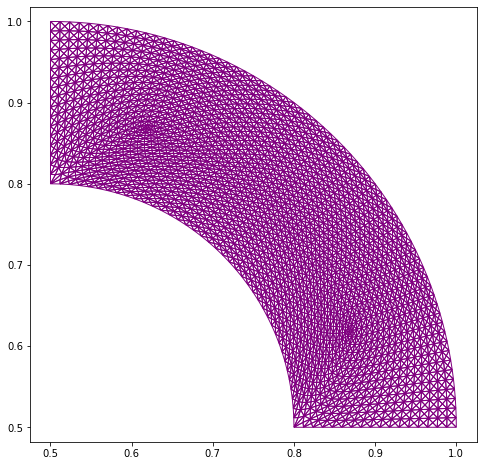

In [18]:
PlotMeshb(xy,eNodes,nE)

## 2.3. Calculate stiffness matrix

In [19]:
K = formStiffness2DT3(nDof,nE,eNodes,nP,xy,C,h,2)
K.shape

(6710, 6710)

## 2.4 Boundary condition

In [20]:
fixP = np.argwhere(xy[:,0]<=0.5+tol)
fixDof = np.array([fixP,fixP+nP], order = 'F')
fixDof = fixDof.flatten()
fixDof

array([   1,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83, 3356, 3422, 3423, 3424,
       3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435,
       3436, 3437, 3438], dtype=int64)

## 2.5 Loading

In [21]:
dfx = 5e7
force = np.zeros((nDof,1))

In [22]:
loadP3 = np.argwhere((xy[:,0]>=0.5) & (xy[:,1]<=0.5+tol))
# loadP3
sort_index = np.argsort(xy[loadP3,0].flatten())
# sort_index

loadP = loadP3.copy()
for i in range(len(sort_index)):
    idi = sort_index[i]
    loadP[i] = loadP3[idi,0]
# loadP

In [23]:
for i in range(len(loadP)-1):
    i0 = loadP[i]
    i1 = loadP[i+1]
    dist = np.sqrt((xy[i0,0]-xy[i1,0])**2 + (xy[i0,1]-xy[i1,1])**2)
    force[i0,0] = force[i0,0] + dfx*dist/2
    force[i1,0] = force[i1,0] + dfx*dist/2
# force[loadP]

## 2.6. Solve EOM

In [24]:
disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

## 2.7. Postprocessing

In [25]:
scale = 0.2
xNew = xy[:,0] + scale*dispu
yNew = xy[:,1] + scale*dispv

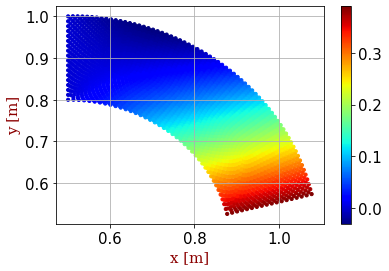

In [26]:
## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

In [27]:
max(dispu)

0.3902701997823039

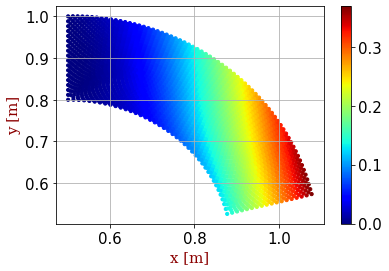

In [28]:
## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)

plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

In [29]:
max(dispv)

0.3686986110848794